# Aligning Noise (Stable Diffusion v2.1)

This notebook goes through a simple example of aligning noise in stable diffusion 2.1.  The goal is to increase the alignment of the input text prompt and the resultant image.  We can do this simply and efficient using a linear combination of the models outputs.

## Setup

First, install the diffusers library.

In [ ]:
%pip install -q diffusers

Import libraries.

In [ ]:
from diffusers import StableDiffusionPipeline
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

Download Stable Diffusion.

In [ ]:
# Download stable diffusion from huggingface
model_id = "stabilityai/stable-diffusion-2-1"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)

# Move model to GPU
device = "cuda:0"
pipe = pipe.to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/537 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/345 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/633 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/824 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/939 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/611 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Define helper functions.

In [ ]:
# Set random seed for reproducability
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)

## Noise Aligning

Our noise aligning algorithm is as follows:

1. $n\sim \mathcal{N}(0,I)$
2. Repeat:
	1. $\nabla \log p(y|n) = \nabla \log p(n|y) - \nabla \log p(n)$
	2. $d = \text{NormClipping}(\nabla \log p(y|n))$
	3. $n = n + d + \mathcal{N}(0,0.001 \cdot I)$
	4. $n = \frac{n\sqrt{d}}{|n|}$

where $y$ is our condition (e.g. a text prompt).

In [ ]:
def align_noise(latents, prompts, device, pipe, aligning_steps=20):

    # Get latent dimensions
    b, c, w, h = latents.shape

    # Duplicate latents for CFG
    t = torch.tensor(999, device=device)
    prompt_embeds, negative_prompt_embeds = pipe.encode_prompt(prompts,device,1,True)
    prompt_embeds = torch.cat([negative_prompt_embeds, prompt_embeds])

    #  Calculate total dimension of the image
    dimensions = len(torch.flatten(latents[0]))

    for _ in range(aligning_steps):
        # Copy noise for conditional/unconditorch.flatten()tion generation
        latent_model_input = torch.cat([latents] * 2)
        latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

        # Predict the noise residual
        noise_pred = pipe.unet(
            latent_model_input.half(),
            t,
            encoder_hidden_states=prompt_embeds.half(),
            return_dict=False,
        )[0]


        # Convert v-prediction to ε-prediction
        sigma = pipe.scheduler.sigmas[0]
        alpha_t, sigma_t = pipe.scheduler._sigma_to_alpha_sigma_t(sigma)
        epsilon = alpha_t * noise_pred + sigma_t * latent_model_input

        # Find the direction
        dir = (epsilon[b:] - epsilon[:b]).detach()

        # Gradient norm clipping of direction
        clip_mag = 0.5
        dir_norm = torch.norm(dir.view(-1, c * w * h), dim=1)
        mask = dir_norm > clip_mag
        dir = torch.where(
            mask[:, None, None, None],
            clip_mag * (dir / dir_norm[:, None, None, None]),
            dir
        ).view(-1, c, w, h)

        # Push the noise in a particular direction
        step_size = 1.0
        latents -= dir * step_size

        # Add a small amount of noise at every step (following arxiv:2303.13703)
        noise_level = 0.001
        latents += torch.tensor(np.random.randn(b, c, w, h), device=device).half() * np.sqrt(noise_level)

        # Normalize latent to be the expected magnitude
        latent_norms = torch.norm(latents.view(-1, c * w * h), dim=1)[:,None,None,None]
        latents = (latents / latent_norms) * np.sqrt(dimensions)

    return latents

## No Guidance Setting

Aligning noise can lead to significant improvements in the case where no guidance is used during generation.  To demonstrate this, first lets generate an image using regular gaussian noise sampled from the standard normal.

In [ ]:
# Generate an image using Gaussian noise
set_seed(14)
prompt = "a portrait photo of an sleepy facial expression"
latents = torch.randn((1, pipe.unet.in_channels, 768 // pipe.vae_scale_factor, 768 // pipe.vae_scale_factor), device=device).half()
with torch.no_grad():
    img_before = pipe(prompt, num_inference_steps=20, latents=latents, guidance_scale=1.0).images[0]

<ipython-input-9-9a57b094e173>:4: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((1, pipe.unet.in_channels, 768 // pipe.vae_scale_factor, 768 // pipe.vae_scale_factor), device=device).half()


  0%|          | 0/20 [00:00<?, ?it/s]

Next, lets align this noise for 20 steps, then use that noise to generate another image.

In [ ]:
# Align noise, then sample an image with that aligned noise
with torch.no_grad():
    aligning_steps = 20
    aligned_latents = align_noise(latents, prompt, device, pipe, aligning_steps)
    img_after = pipe(prompt, num_inference_steps=20, latents=aligned_latents, guidance_scale=1.0).images[0]

  0%|          | 0/20 [00:00<?, ?it/s]

Now, lets display the images we generated.

Text(0.5, 0.98, 'PROMPT: "a portrait photo of an sleepy facial expression"')

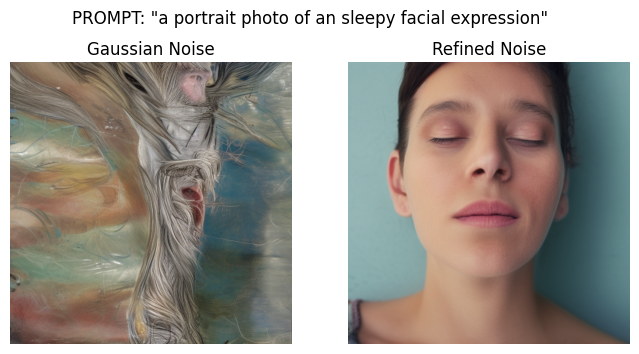

In [ ]:
# Display generated images
fig, axs = plt.subplots(1, 2, figsize=(8,4))
axs[0].imshow(img_before)
axs[0].set_title("Gaussian Noise")
axs[0].axis('off')
axs[1].imshow(img_after)
axs[1].set_title("Aligned Noise")
axs[1].axis('off')
fig.suptitle("PROMPT: " + "\"" + prompt + "\"")

([], [])

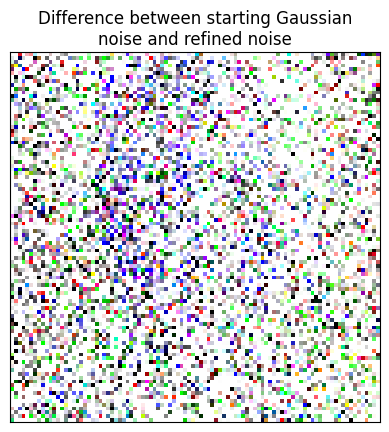

In [ ]:
diff = np.transpose((latents - aligned_latents)[0].cpu().float().numpy(), (1,2,0))
plt.imshow(diff*5)
plt.title("Difference between starting Gaussian\nnoise and aligned noise")
plt.xticks([])
plt.yticks([])

## Guidance Setting

Aligned noise is also sometimes useful when also using classifier-free guidance during generation.  In the example below, we see an image that is poorly aligned with the input prompt.  Aligned noise increases the likelihood of our prompt, leading to an image that is better aligned with the condition.

In [ ]:
with torch.no_grad():
    img_before = pipe(prompt, num_inference_steps=20, latents=latents).images[0]

  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
# Align noise, then sample an image with that aligned noise
with torch.no_grad():
    img_after = pipe(prompt, num_inference_steps=20, latents=aligned_latents).images[0]

  0%|          | 0/20 [00:00<?, ?it/s]

Text(0.5, 0.98, 'PROMPT: "a portrait photo of an sleepy facial expression"')

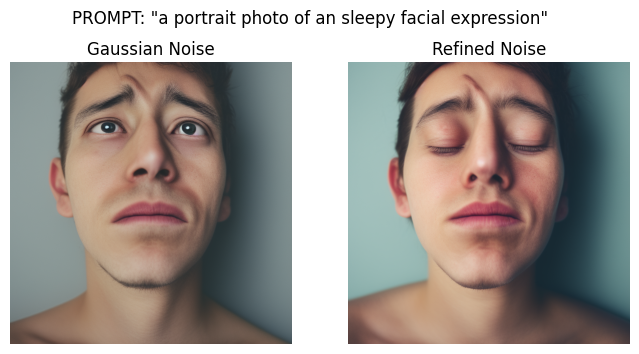

In [ ]:
# Display generated images
fig, axs = plt.subplots(1, 2, figsize=(8,4))
axs[0].imshow(img_before)
axs[0].set_title("Gaussian Noise")
axs[0].axis('off')
axs[1].imshow(img_after)
axs[1].set_title("Aligned Noise")
axs[1].axis('off')
fig.suptitle("PROMPT: " + "\"" + prompt + "\"")